## Loading necessary packages

In [34]:
pip install casadi matplotlib numpy

In [35]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

## Defining constraints

In [36]:
# obstacle constraints

def get_rectangle_halfspace(x_center, y_center, width, height):
    # Axis-aligned rectangle
    A = np.array([[ 1, 0],
                  [-1, 0],
                  [0,  1],
                  [0, -1]])
    b = np.array([x_center + width/2,
                 -x_center + width/2,
                  y_center + height/2,
                 -y_center + height/2])
    return A, b

In [37]:
def add_obca_constraints_opti(opti, X, LAMB, MU, A_list, b_list, ego_shape, dmin):
    """
    Adds OBCA-style obstacle avoidance constraints using ca.Opti().

    Parameters:
    - opti: casadi.Opti instance
    - X: Opti variable (4 x N+1) state trajectory
    - LAMB: Opti variable (total_m x N+1) dual variables for obstacle constraints
    - MU: Opti variable (4*n_obs x N+1) dual variables for ego shape
    - A_list: list of (m x 2) numpy arrays, halfspace normals for each obstacle
    - b_list: list of (m,) numpy arrays, halfspace offsets for each obstacle
    - ego_shape: array of 4 floats, g vector for ego (rectangle with 4 sides)
    - dmin: float, minimum distance
    """
    N = X.shape[1]
    n_obs = len(A_list)
    offset = (ego_shape[0]+ego_shape[2])/2 - ego_shape[2]
    # offset = ego_shape[0]

    g_obs = ca.DM(ego_shape)
    m_list = [A.shape[0] for A in A_list]
    cum_m = np.cumsum([0] + m_list)

    for k in range(N):
        theta_k = X[2, k]
        R = ca.vertcat(
            ca.horzcat(ca.cos(theta_k), -ca.sin(theta_k)),
            ca.horzcat(ca.sin(theta_k), ca.cos(theta_k))
        )

        xk = X[0, k]
        yk = X[1, k]
        t = ca.vertcat(xk + offset * ca.cos(theta_k),
                       yk + offset * ca.sin(theta_k))

        for j in range(n_obs):
            A = ca.DM(A_list[j])
            b = ca.DM(b_list[j])
            m = A.shape[0]
            lamb_jk = LAMB[cum_m[j]:cum_m[j+1], k]
            mu_jk = MU[4*j:4*(j+1), k]

            # Constraint 1: norm(A^T * λ) ≤ 1
            norm_sq = ca.sumsqr(A.T @ lamb_jk)
            opti.subject_to(norm_sq <= 1)

            # Constraint 2: G^T * μ + R^T * A^T * λ = 0
            G_mu = ca.vertcat(-mu_jk[0] + mu_jk[2],
                              -mu_jk[1] + mu_jk[3])
            AT_lambda = A.T @ lamb_jk
            dual_eq = G_mu + R.T @ AT_lambda
            opti.subject_to(dual_eq == 0)

            # Constraint 3: separation ≥ dmin
            A_t = A @ t
            sep = -ca.dot(g_obs, mu_jk) + ca.dot(A_t - b, lamb_jk)
            opti.subject_to(sep >= dmin)


In [38]:
# Dynamics
def f_dyn(x, u):
    xdot = x[3] * ca.cos(x[2])
    ydot = x[3] * ca.sin(x[2])
    thetadot = x[3] / L * ca.tan(u[1])
    vdot = u[0]
    return ca.vertcat(xdot, ydot, thetadot, vdot)

In [39]:
nx = 4 #state variale dimension -- x, y, theta, v
nu = 2 # control var dimension -- a, delta

# Vehicle model
L = 2
W = L/2

# Initial and final state
x_init = np.array([0.0, 0.0, 0.0, 0.0])
# x_goal = np.array([10.0, 0.0, 0.0, 0.0])
x_goal = np.array([7.5, -3.25, 0.0, 0.0])

# Time horizon and discretization
N = 100  # number of control intervals
T = 10.0  # total time
dt = T / N

# Cost weights
Q = np.diag([40, 40, 20, 20])*10 #np.diag([1, 1, 1, 20])
Qf = np.diag([80, 80, 20, 20])*10 #np.diag([22, 22, 1, 20])
R = np.diag([1, 0.1]) #np.diag([0.1, 0.01])

# Optimization problem
opti = ca.Opti()

# Decision variables
X = opti.variable(nx, N+1)
U = opti.variable(nu, N)

# Define the cost function
cost = 0
for k in range(N):
    cost += ca.mtimes((X[:,k] - x_goal).T, Q @ (X[:,k] - x_goal))
    cost += ca.mtimes(U[:,k].T,R @ U[:,k])  # minimize control effort

# Terminal cost
cost += ca.mtimes((X[:,N] - x_goal).T, Qf @ (X[:,N] - x_goal))

opti.minimize(cost)


In [40]:
# Define obstacles
obstacles = [
    (3, -4, 6, 3),   # (x_center, y_center, width, height)
    (7.5, -4.75, 3, 1.5),
    (12, -4, 6, 3)
]
A_obs1, b_obs1 = get_rectangle_halfspace(*obstacles[0])
A_obs2, b_obs2 = get_rectangle_halfspace(*obstacles[1])
A_list = [A_obs1, A_obs2]
b_list = [b_obs1, b_obs2]

total_m = sum(A.shape[0] for A in A_list)
LAMB = opti.variable(total_m, N+1)
MU = opti.variable(nx * len(A_list), N+1)

In [41]:
# Bounds
v_min, v_max = -1.0, 2.0
a_min, a_max = -1.0, 1.0
delta_min, delta_max = -1, 1

for k in range(N+1):
    opti.subject_to(X[3,k] >= v_min)
    opti.subject_to(X[3,k] <= v_max)

for k in range(N):
    opti.subject_to(U[0,k] >= a_min)
    opti.subject_to(U[0,k] <= a_max)
    opti.subject_to(U[1,k] >= delta_min)
    opti.subject_to(U[1,k] <= delta_max)

In [42]:
# Dynamics constraints
for k in range(N):
    x_next = X[:,k] + dt * f_dyn(X[:,k], U[:,k])
    opti.subject_to(X[:,k+1] == x_next)

# Initial condition
opti.subject_to(X[:,0] == x_init)
opti.subject_to(X[:,-1] == x_goal)

In [49]:
# add obstacle constraint
# Type case = 1 for point mass model
# OR type case = 2 for full dimensional object
case = 2
if case == 1:
    add_obca_constraints_opti(opti, X, LAMB, MU, A_list, b_list, ego_shape=[0.0, 0.0, 0.0, 0.0], dmin=0.3) # point mass
    opti.subject_to(ca.vec(LAMB) >= 0)
    opti.subject_to(ca.vec(MU) >= 0)
else:
  add_obca_constraints_opti(opti, X, LAMB, MU, A_list, b_list, ego_shape=[L/2, W/2, L/2, W/2], dmin=0.1) # full dimensional
  opti.subject_to(ca.vec(LAMB) >= 0)
  opti.subject_to(ca.vec(MU) >= 0)



In [50]:
# Initial guess (linear interpolation)
x_guess = np.zeros((4, N+1))
u_guess = np.zeros((2, N))
for k in range(N+1):
    x_guess[:,k] = x_init + (x_goal - x_init) * k / N
opti.set_initial(X, x_guess)
opti.set_initial(U, u_guess)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 209.22ms (549.13us) 208.06ms (546.08us)       381
       nlp_g  |   1.42 s (  3.73ms)   1.44 s (  3.77ms)       381
  nlp_grad_f  | 192.12ms (568.39us) 192.40ms (569.23us)       338
  nlp_hess_l  |   4.44 s ( 12.59ms)   4.47 s ( 12.68ms)       353
   nlp_jac_g  |   4.82 s ( 13.49ms)   4.85 s ( 13.58ms)       357
       total  |  36.51 s ( 36.51 s)  36.74 s ( 36.74 s)         1


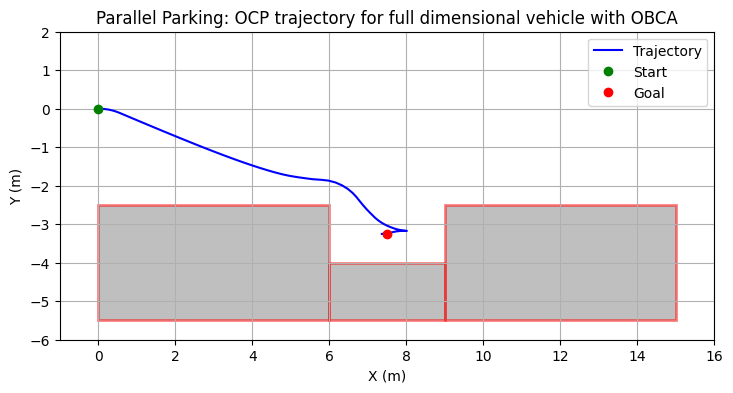

In [51]:
# Solver setup
opts = {
    'ipopt': {
        'print_level': 0,
        'max_iter': 5000,
        'tol': 1e-6,
        'acceptable_tol': 1e-4
    }
}
opti.solver('ipopt', opts)

# Solve
sol = opti.solve()

# Extract solution
X_opt = sol.value(X)
U_opt = sol.value(U)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 4))

# Plot trajectory, start, and goal
ax.plot(X_opt[0, :], X_opt[1, :], 'b-', label='Trajectory')
ax.plot(x_init[0], x_init[1], 'go', label='Start')
ax.plot(x_goal[0], x_goal[1], 'ro', label='Goal')

# Plot obstacles
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = patches.Rectangle((x_c - w/2, y_c - h/2), w, h,
                             linewidth=2, edgecolor='red', facecolor='gray', alpha=0.5)
    ax.add_patch(rect)

# Final formatting
ax.set_aspect('equal')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_ylim(-6, 2)
ax.set_xlim(-1, 16)
ax.set_title('Parallel Parking: OCP trajectory for full dimensional vehicle with OBCA')
ax.legend()
ax.grid(True)
fig.savefig("ocp_PointMass_ParallelPark_traj.png", dpi = 300, bbox_inches ="tight")
plt.show()


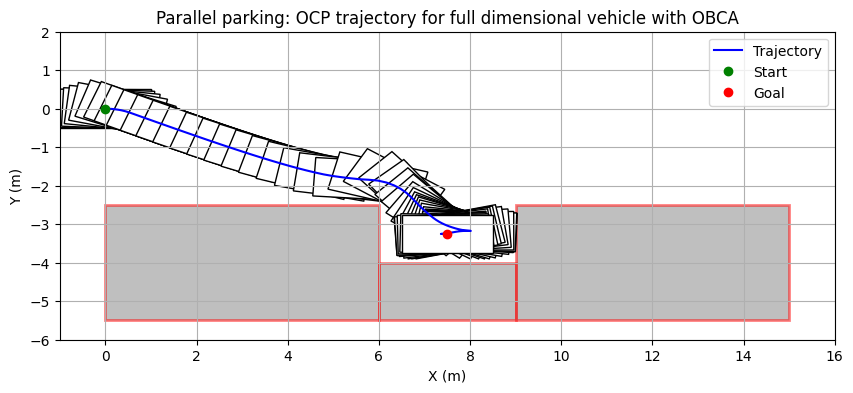

In [54]:
# Trajectory plot
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(X_opt[0, :], X_opt[1, :], 'b-', label='Trajectory')
ax.plot(x_init[0], x_init[1], 'go', label='Start')
ax.plot(x_goal[0], x_goal[1], 'ro', label='Goal')
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = Rectangle((x_c - w/2, y_c - h/2), w, h,
                             linewidth=2, edgecolor='red', facecolor='gray', alpha=0.5)
    ax.add_patch(rect)

for i in range(0, N+1, 2):
    veh_pose = Rectangle((X_opt[0, i] - L/2, X_opt[1, i] - W/2), L, W,
                      facecolor='white', edgecolor='black', alpha=1)

    trans = Affine2D().rotate_deg_around(X_opt[0, i], X_opt[1, i], np.rad2deg(X_opt[2, i])) + ax.transData
    veh_pose.set_transform(trans)

    ax.add_patch(veh_pose)

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_ylim(-6, 2)
ax.set_xlim(-1, 16)
#ax.set_xticklabels(np.linspace(-1, 18, 20))
ax.grid(True)
ax.set_title("Parallel parking: OCP trajectory for full dimensional vehicle with OBCA")
ax.legend()
fig.savefig("June6_ocp_fullDim_ParallerPark_colFree_FinalRep.png", dpi=300, bbox_inches='tight')
plt.show()
fig.clf()
plt.close(fig)

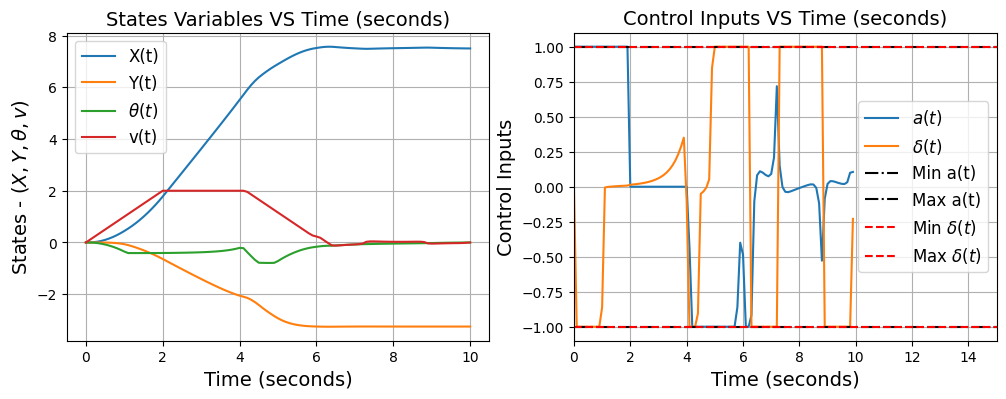

In [47]:
t_eval = np.linspace(0, T, N+1)

# Time series plot for state variables (X, Y, theta, v) of the point mass model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
legend_s = ['X(t)', 'Y(t)', r'$\theta(t)$', 'v(t)']
for i in range(nx):
    ax1.plot(t_eval, X_opt[i, :], label = legend_s[i])
ax1.legend(fontsize=12);
ax1.set_title("States Variables VS Time (seconds)", fontsize=14)
ax1.grid(True)
ax1.set_xlabel("Time (seconds)", fontsize=14)
ax1.set_ylabel(r"States - $(X, Y, \theta, v)$", fontsize=14)

# Time series plot for control variables (a, steering angle) of the point mass model
legend_u = [r'$a(t)$', r'$\delta(t)$']
for i in range(nu):
    ax2.plot(t_eval[:-1], U_opt[i, :], label = legend_u[i])
ax2.axhline(y=-1, color='k', linestyle='-.', label = r'Min a(t)')
ax2.axhline(y=1, color='k', linestyle='-.', label = r'Max a(t)')
ax2.axhline(y=-1, color='r', linestyle='--', label = r'Min $\delta(t)$')
ax2.axhline(y=1, color='r', linestyle='--', label = r'Max $\delta(t)$')
ax2.legend(fontsize=12);
ax2.set_title("Control Inputs VS Time (seconds)", fontsize=14)
ax2.grid(True)
ax2.set_xlabel("Time (seconds)", fontsize=14)
ax2.set_ylabel("Control Inputs", fontsize=14)
ax2.set_xlim([0, 15])
plt.show()
fig.savefig("ocp_timeSeries_parPark_FullDim.png", dpi=300, bbox_inches='tight')
fig.clf()
plt.close(fig)

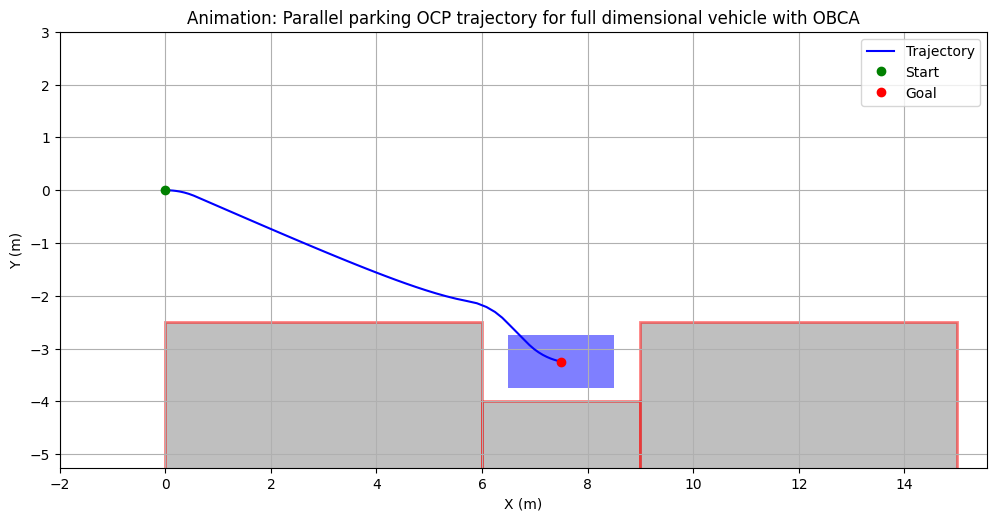

In [48]:
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Car dimensions
car_length = L
car_width = W

# Set up figure
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout()
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_xlim(np.min(X_opt[0, :]) - 2, np.max(X_opt[0, :]) + 8)
ax.set_ylim(np.min(X_opt[1, :]) - 2, np.max(X_opt[1, :]) + 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_title("Animation: Parallel parking OCP trajectory for full dimensional vehicle with OBCA")

# Initialize plot elements
trajectory_line, = ax.plot([], [], 'b-', label='Trajectory')
start_point = ax.plot(x_init[0], x_init[1], 'go', label='Start')[0]
goal_point = ax.plot(x_goal[0], x_goal[1], 'ro', label='Goal')[0]

# Car rectangle initialized at (0, 0) relative to its own frame
car_patch = Rectangle((-car_length / 2, -car_width / 2), car_length, car_width,
                      facecolor='blue', alpha=0.5)
ax.add_patch(car_patch)

# Plot obstacles
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = Rectangle((x_c - w/2, y_c - h/2), w, h,
                     linewidth=2, edgecolor='red', facecolor='gray', alpha=0.5)
    ax.add_patch(rect)
ax.legend()

def update(frame):
    x, y, theta = X_opt[0, frame], X_opt[1, frame], X_opt[2, frame]

    # Update trajectory
    trajectory_line.set_data(X_opt[0, :frame+1], X_opt[1, :frame+1])

    # Apply transformation: rotate and then translate the car
    transform = Affine2D().rotate(theta).translate(x, y) + ax.transData
    car_patch.set_transform(transform)

    return trajectory_line, car_patch

# Animate
ani = animation.FuncAnimation(fig, update, frames=X_opt.shape[1], interval=100, blit=True)

# Save
ani.save("ParallelPark_ocp_trajectory.gif", writer='pillow', fps=10)

plt.show()
